In [1]:
#require "owl-top"
#require "owl-ode"
#require "juplot"

/Users/mseri/.opam/4.08.1/lib/ocaml/unix.cma: loaded
/Users/mseri/.opam/4.08.1/lib/ocaml/bigarray.cma: loaded
/Users/mseri/.opam/4.08.1/lib/bytes: added to search path
/Users/mseri/.opam/4.08.1/lib/integers: added to search path
/Users/mseri/.opam/4.08.1/lib/integers/integers.cma: loaded
/Users/mseri/.opam/4.08.1/lib/ctypes: added to search path
/Users/mseri/.opam/4.08.1/lib/ctypes/ctypes.cma: loaded
/Users/mseri/.opam/4.08.1/lib/ctypes/ctypes-top.cma: loaded
/Users/mseri/.opam/4.08.1/lib/ocaml/str.cma: loaded
/Users/mseri/.opam/4.08.1/lib/ctypes/cstubs.cma: loaded
/Users/mseri/.opam/4.08.1/lib/eigen/cpp: added to search path
/Users/mseri/.opam/4.08.1/lib/eigen/cpp/eigen_cpp.cma: loaded
/Users/mseri/.opam/4.08.1/lib/eigen: added to search path
/Users/mseri/.opam/4.08.1/lib/eigen/eigen.cma: loaded
/Users/mseri/.opam/4.08.1/lib/owl-base: added to search path
/Users/mseri/.opam/4.08.1/lib/owl-base/owl_base.cma: loaded
/Users/mseri/.opam/4.08.1/lib/owl: added to search path
/Users/mseri/.o

# N-Body system

We generate 1000 normally distributed bodies around 0 and of equal mass, and define the energy and the potential of the system.

In [2]:
open Owl

let n_planets = 1000
let planets = Mat.gaussian n_planets 3
let planetvs = Mat.zeros n_planets 3
let shift = Mat.create n_planets 1 1E-10

let nbody_owl planets =
  let force = Mat.zeros n_planets 3 in
  for i = 0 to n_planets - 1 do
    let open Mat in
    let dp = planets - planets.${[ [ i ]; [] ]} in
    let dr_sqr = l2norm_sqr ~axis:1 dp in
    let dr_pow_n32 = 1. $/ max2 (dr_sqr + sqrt dr_sqr) shift in
    force.${[ []; [] ]} <- (force.${[ []; [] ]} - (dp * dr_pow_n32))
  done;
  force

let energy planets planetvs =
  let open Mat in
  let e = ref @@ sum' (l2norm_sqr ~axis:1 planetvs *$ 0.5) in
  for i = 0 to pred n_planets do
    let dp = planets - planets.${[ [ i ]; [] ]} in
    let dr_sqr = l2norm_sqr ~axis:1 dp in
    let dr_pow_n32 = 1. $/ max2 (dr_sqr + sqrt dr_sqr) shift in
    e := !e -. sum' dr_pow_n32
  done;
  !e

val n_planets : int = 1000


val planets : Owl.Mat.mat =
  
            C0        C1        C2 
  R0   1.13045   0.54233  0.683782 
  R1  0.222174  -0.16928  0.589529 
  R2 -0.869412 -0.493556  -1.52631 
  R3  -0.79634  -1.70364  0.748004 
  R4 -0.644123  0.169237 -0.858031 
           ...       ...       ... 
R995   1.11452  -1.33682  -1.05919 
R996   0.22954 -0.330798  -1.41963 
R997 -0.102134  0.926583  -1.23885 
R998   1.35156  -1.94758  0.345715 
R999 -0.378244  0.422518   1.80029 



val planetvs : Owl.Mat.mat =
  
      C0  C1  C2 
  R0   0   0   0 
  R1   0   0   0 
  R2   0   0   0 
  R3   0   0   0 
  R4   0   0   0 
     ... ... ... 
R995   0   0   0 
R996   0   0   0 
R997   0   0   0 
R998   0   0   0 
R999   0   0   0 



val shift : Owl.Mat.mat =
  
        C0 
  R0 1E-10 
  R1 1E-10 
  R2 1E-10 
  R3 1E-10 
  R4 1E-10 
       ... 
R995 1E-10 
R996 1E-10 
R997 1E-10 
R998 1E-10 
R999 1E-10 



val nbody_owl :
  (float, Bigarray.float64_elt) Owl_dense_matrix_generic.t -> Owl.Mat.mat =
  <fun>


val energy :
  (float, Bigarray.float64_elt) Owl_dense_matrix_generic.t ->
  Owl.Mat.mat -> Owl.Mat.elt = <fun>


# Integration of the system

In [3]:
let advance dt (planets, planetevs) =
  let f (planets, _) _ = nbody_owl planets in
  Owl_ode.Symplectic.D.Symplectic_Euler.step f ~dt (planets, planetevs) 0.0

val advance :
  float ->
  Owl_ode__Symplectic_d.mat * Owl_ode__Symplectic_d.mat ->
  Owl_ode.Symplectic.D.Symplectic_Euler.step_output = <fun>


In [4]:
let n = 80
let dt = 0.5
let y0 = planets, planetvs
let tspec = Owl_ode.Types.T1 { t0 = 0.0; dt; duration = float_of_int n *. dt }
let f (planets, _) _ = nbody_owl planets

val n : int = 80


val dt : float = 0.5


val y0 : Owl.Mat.mat * Owl.Mat.mat =
  (
            C0        C1        C2 
  R0   1.13045   0.54233  0.683782 
  R1  0.222174  -0.16928  0.589529 
  R2 -0.869412 -0.493556  -1.52631 
  R3  -0.79634  -1.70364  0.748004 
  R4 -0.644123  0.169237 -0.858031 
           ...       ...       ... 
R995   1.11452  -1.33682  -1.05919 
R996   0.22954 -0.330798  -1.41963 
R997 -0.102134  0.926583  -1.23885 
R998   1.35156  -1.94758  0.345715 
R999 -0.378244  0.422518   1.80029 
,
   
      C0  C1  C2 
  R0   0   0   0 
  R1   0   0   0 
  R2   0   0   0 
  R3   0   0   0 
  R4   0   0   0 
     ... ... ... 
R995   0   0   0 
R996   0   0   0 
R997   0   0   0 
R998   0   0   0 
R999   0   0   0 
)


val tspec : Owl_ode.Types.tspec =
  Owl_ode.Types.T1 {Owl_ode.Types.t0 = 0.; duration = 40.; dt = 0.5}


val f :
  (float, Bigarray.float64_elt) Owl_dense_matrix_generic.t * 'a ->
  'b -> Owl.Mat.mat = <fun>


In [5]:
let tspan, sol_planets, sol_planetevs = Owl_ode.(Ode.odeint Symplectic.D.leapfrog f y0 tspec ())

val tspan : Owl_ode.Symplectic.D.mat =
  
      C0 
 R0    0 
 R1  0.5 
 R2    1 
 R3  1.5 
 R4    2 
     ... 
R76   38 
R77 38.5 
R78   39 
R79 39.5 
R80   40 

val sol_planets : Owl_ode.Symplectic.D.mat =
  
          C0       C1       C2       C3       C4        C2995    C2996     C2997    C2998    C2999 
 R0  1.13045  0.54233 0.683782 0.222174 -0.16928 ... -1.94758 0.345715 -0.378244 0.422518  1.80029 
 R1 -19.5096  -10.254 -11.5007 -4.42283  2.50915 ...  21.0636 -4.13663     5.952 -6.54812 -24.5348 
 R2 -35.7256  -18.637 -21.2957  -8.1079  4.45263 ...  39.4256 -7.73366   10.7523 -12.0054 -45.5389 
 R3 -49.5204  -25.694 -29.7875 -11.2691  5.99649 ...  55.2031 -10.8384   14.7182 -16.6251 -63.6164 
 R4 -61.5697 -31.7938 -37.3409  -14.052   7.2531 ...  69.1072 -13.5862   18.0863 -20.6361 -79.5838 
         ...      ...      ...      ...      ... ...      ...      ...       ...      ...      ... 
R76  27.5001  42.3628 -86.4588  14.0314   62.753 ... -435.643  122.161   19.0602   30.706

In [6]:
let energies = Mat.zeros (n+1) 2
let e0 = energy planets planetvs

val energies : Owl.Mat.mat =
  
     C0  C1 
 R0   0   0 
 R1   0   0 
 R2   0   0 
 R3   0   0 
 R4   0   0 
    ... ... 
R76   0   0 
R77   0   0 
R78   0   0 
R79   0   0 
R80   0   0 



val e0 : Owl.Mat.elt = -10000000226758.4082


In [7]:
for i=0 to n do
    Mat.set energies i 0 (Mat.get tspan i 0);
    Mat.set energies i 1 Mat.(
    energy (reshape (row sol_planets i)  [|1000; 3|]) (reshape (row sol_planetevs i)  [|1000; 3|])
        /. e0
    );
done

- : unit = ()


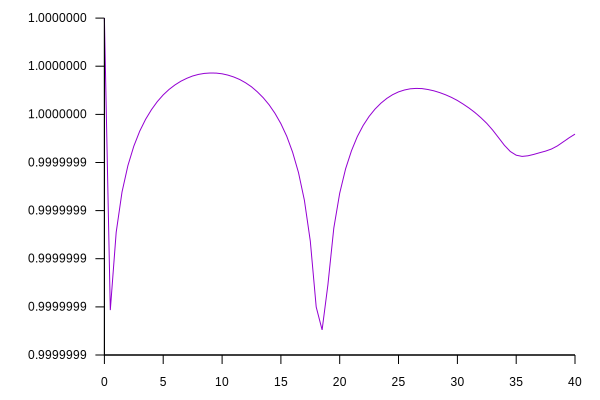

- : unit = ()


In [8]:
let figure (module F: Gp.Plot) =
    F.plot (A energies) ~using:"1:2" ~style:"l" []
  in
  Juplot.draw figure

# Can we animate the bodies?

In [9]:
let plot planets (module F: Gp.Plot) =
    let planets = Mat.(reshape planets [|1000; 3|]) in
    F.splot (A planets) ~using:"1:2:3" ~style:"p pt 7 ps 0.5" Gp.[unset "xtics"; unset "ytics"; unset "ztics"]

val plot : Owl.Mat.mat -> (module Gp.Plot) -> unit = <fun>


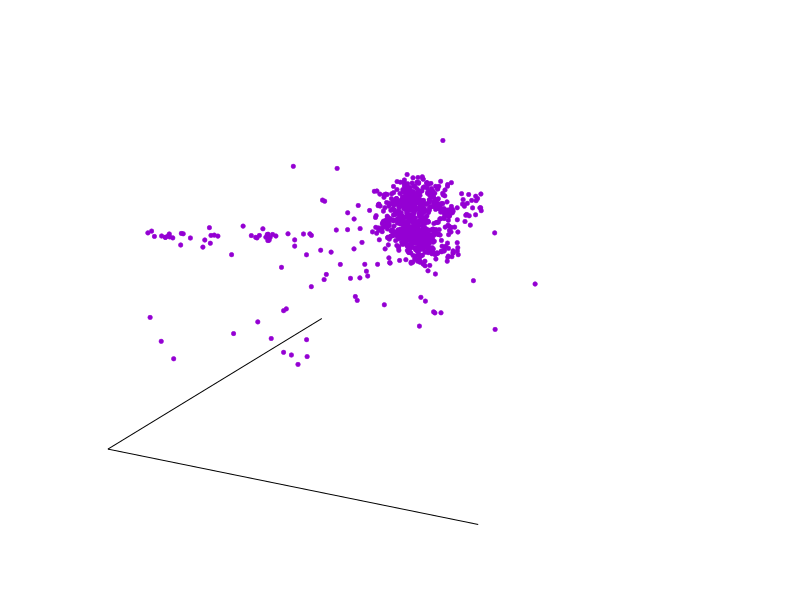

val display_id : Jupyter_notebook.display_id = <abstr>


In [10]:
let display_id = Jupyter_notebook.display "text/html" ""
let () =
    Mat.iter_rows (fun planets -> 
        Juplot.draw ~fmt:`svg ~size:(800,600) ~display_id (plot planets);
        Unix.sleepf 0.05
    ) sol_planets